### IMPLEMENTATION OF DEEP LEARNING MODELS FOR SENTIMENT ANALYSIS OF IMDB MOVIE REVIEWS.
* This notebooks contains the implementation of a Deep Neural Network (DNN), Convolutional Neural Network (CNN), and recurrent Neural Network (LSTM) for sentiment analysis.
* The dataset used is **"Sentiment Labelled Sentences Dataset", from the UC Irvine Machine Learning Repository.**
* The sentences come from three different websites/fields:
    * amazon.com
    * imdb.com
    * yelp.com
* In this notebook, only the IMDB movie reviews dataset is used.
* Each sentence is labelled as either 1 (for positive) or 0 (for negative).
* There exist 500 positive and 500 negative sentences.
* This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015.  *(Please cite the paper if you want to use it :))*

* Link to the dataset is: [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Importing modules:
We are importing two custom built libraries namely "TextPreprocessing.py" and "Model.py".
1. The **TextPreprocessing.py** file contains methods for reading the dataset, preprocessing it, generating tokens, and word embeddings.
2. The **Model.py** file contains the Callback class as well as methods in which the DNN, CNN and RNN architectures are defined. It also contains methods to save, and plot models as well as predict class label.

In [1]:
from TextPreprocessing import TextPreprocessing
import Model as model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
max_words = 10000
oov_word = "<00V>"
padding_type = "post"
truncating_type = "post"
pad_len = 100

* Create an object of TextPreprocessing class.
* This calls contains all the methods for text Preprocesing and vectorizaiton.
* Passing "IMDB" as the argument to the consturctor indicates that it must use the IMDB Movie Reviews dataset.

In [4]:
tp = TextPreprocessing('IMDB')

In [5]:
corpus, labels = tp.get_data()

In [6]:
df = pd.DataFrame(list(zip(corpus,labels)), columns=['corpus', 'labels'])

In [7]:
df.head()

,corpus,labels
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [8]:
# Preprocess the dataset
X = []
for c in df['corpus'].values:
    X.append(tp.preprocess_text(c))

In [9]:
print(df['corpus'].values[131])
print(X[131])
print(df['labels'].values[131])

print("\n"+df['corpus'].values[543])
print(X[543])
print(df['labels'].values[543])

There were several moments in the movie that just didn't need to be there and were excruciatingly slow moving.  
several moment movie didn need excruciatingly slow move
0

However, after seeing the short again after about 25 years, I was amazed at how timeless the film actually is.  
however see short year amaze how timeless film actually
1


In [10]:
#Splitting into training(80%) and testing data(20%)
X_train, X_test, y_train, y_test = train_test_split(X, df['labels'].values, test_size=0.20, random_state=42, shuffle=True)

In [11]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_train = np.array(y_train, dtype=np.float32)
y_test = y_test.reshape(y_test.shape[0], -1)
y_test = np.array(y_test, dtype=np.float32)

In [12]:
#Tokenize and Pad the text sequences
tokenizer, vocab_size, X_train_padded, X_test_padded = tp.tokenizer_and_pad_training(X_train, X_test, max_words, oov_word, padding_type, truncating_type, pad_len)

In [13]:
print(X_train_padded.shape)
print(y_train.shape)
print(X_test_padded.shape)
print(y_test.shape)

(800, 100)
(800, 1)
(200, 100)
(200, 1)


### Word Embeddings:
* GloVe Word Embeddings are used. 
* Each word is represented as a 100 dimensional feature vector.
* The file contains embedings for the most frequently used 6 billion words in the english language.

In [14]:
embedding_matrix = tp.get_embedding_metrix(vocab_size, tokenizer)

In [15]:
print(embedding_matrix.shape)

(2188, 100)


In [16]:
input_dim = vocab_size
embedding_dim = 100
input_len = pad_len

myCB = model.myCallbacks()

### Deep Neural Network Model:
* A DNN architecture consists of an Embedding layer, followed by a GlobalMaxPooling1D and three Dense layers.
* Pretained GloVe Word Embeddings are used which are again trained according to the dataset.
* First Dense layer contains 64 hidden units, and second Dense layer contains 32 hidden units with relu activation.
* Weight decay / L2 regularization with lambda=0.015 is used in both the dense layers to reduce overfitting.
* The output layer is a Dense layer with a single hidden unit using softmax activation.
* Adam optimizer and binary crossentropy loss is used.
* The model is trained with a batch size of 32 for 40 epochs / unitl training accuracy reaches 99%.

In [21]:
myDNN = model.create_model_DNN(input_dim, embedding_dim, embedding_matrix, input_len, trainable=True, n1=64, n2=32, kr=l2(0.015))
myDNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          218800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 227,377
Trainable params: 227,377
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = myDNN.fit(X_train_padded, y_train, epochs=40, batch_size=32, verbose=1, validation_data = (X_test_padded, y_test), callbacks=[myCB])

Epoch 1/40
25/25 [==============================] - 0s 18ms/step - loss: 2.3147 - acc: 0.5362 - val_loss: 2.0855 - val_acc: 0.5350
Epoch 2/40
25/25 [==============================] - 0s 12ms/step - loss: 1.8957 - acc: 0.6413 - val_loss: 1.7260 - val_acc: 0.6600
Epoch 3/40
25/25 [==============================] - 0s 12ms/step - loss: 1.5624 - acc: 0.7175 - val_loss: 1.4388 - val_acc: 0.7050
Epoch 4/40
25/25 [==============================] - 0s 10ms/step - loss: 1.2930 - acc: 0.7875 - val_loss: 1.2189 - val_acc: 0.7650
Epoch 5/40
25/25 [==============================] - 0s 12ms/step - loss: 1.0708 - acc: 0.8012 - val_loss: 1.0530 - val_acc: 0.7450
Epoch 6/40
25/25 [==============================] - 0s 12ms/step - loss: 0.8869 - acc: 0.8512 - val_loss: 0.9826 - val_acc: 0.7250
Epoch 7/40
25/25 [==============================] - 0s 12ms/step - loss: 0.7607 - acc: 0.8700 - val_loss: 0.8988 - val_acc: 0.7400
Epoch 8/40
25/25 [==============================] - 0s 11ms/step - loss: 0.6625 - a

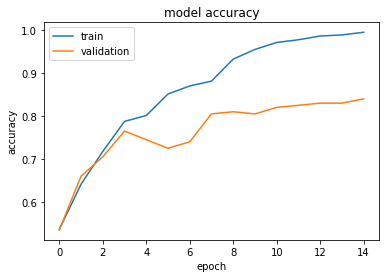

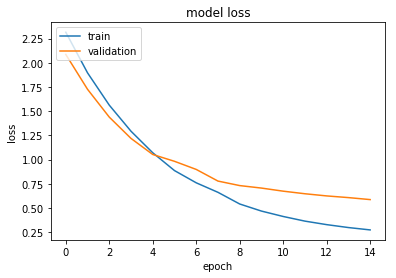

In [23]:
model.plot_curves(history)

### Results:
* We get a training accuracy of 99.50% and testing accuracy of 84.00%.
* The training loss is 0.2745 and testing loss is 0.5875 .

In [25]:
model.save_model(myDNN, "IMDB/DNN_n164_n232_kr0015_vacc84")

### Convolutional Neural Network Model:
* A CNN architecture consists of an Embedding layer, followed by a Conv21D layer, GlobalMaxPooling1D layer, Dropout Layer and Dense layer.
* Pretained GloVe Word Embeddings are used which are again trained according to the dataset.
* The Conv21D layer contains 128 hidden units, with kernel size 5.
* Weight decay / L2 regularization with lambda=0.02 is used for the Convolutional layer to reduce overfitting.
* A dropout of 25% is implemented.
* The output layer is a Dense layer with a single hidden unit using softmax activation.
* Adam optimizer and binary crossentropy loss is used.
* The model is trained with a batch size of 32 for 40 epochs / unitl training accuracy reaches 99%.

In [35]:
myCNN = model.create_model_CNN(input_dim, embedding_dim, embedding_matrix, input_len, trainable=True, n1=128, k=5, d=0.25, kr=l2(0.02))
myCNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          218800    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 283,057
Trainable params: 283,057
Non-trainable params: 0
_________________________________________________________________


In [36]:
history1 = myCNN.fit(X_train_padded, y_train, epochs=40, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=[myCB], verbose=1)

Epoch 1/40
25/25 [==============================] - 1s 47ms/step - loss: 2.4938 - acc: 0.5950 - val_loss: 1.9914 - val_acc: 0.7350
Epoch 2/40
25/25 [==============================] - 1s 46ms/step - loss: 1.6068 - acc: 0.8000 - val_loss: 1.4183 - val_acc: 0.7550
Epoch 3/40
25/25 [==============================] - 1s 42ms/step - loss: 1.1059 - acc: 0.8813 - val_loss: 1.0843 - val_acc: 0.7650
Epoch 4/40
25/25 [==============================] - 1s 41ms/step - loss: 0.8132 - acc: 0.9137 - val_loss: 0.8814 - val_acc: 0.8300
Epoch 5/40
25/25 [==============================] - 1s 40ms/step - loss: 0.6390 - acc: 0.9250 - val_loss: 0.7586 - val_acc: 0.8300
Epoch 6/40
25/25 [==============================] - 1s 39ms/step - loss: 0.5189 - acc: 0.9413 - val_loss: 0.6820 - val_acc: 0.8450
Epoch 7/40
25/25 [==============================] - 1s 40ms/step - loss: 0.4254 - acc: 0.9575 - val_loss: 0.6197 - val_acc: 0.8350
Epoch 8/40
25/25 [==============================] - 1s 39ms/step - loss: 0.3707 - a

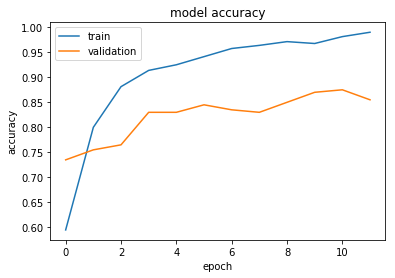

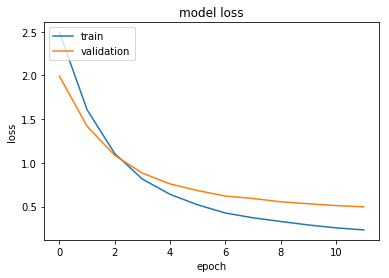

In [37]:
model.plot_curves(history1)

### Results:
* We get a training accuracy of 99.00% and testing accuracy of 85.50%.
* The training loss is 0.2321 and testing loss is 0.4965 .

In [38]:
model.save_model(myCNN, "IMDB/CNN_n128_D025_kr002_vacc85")

### Recurrent Neural Network Model:
* A RNN architecture consists of an Embedding layer, followed by a Bidirectional LSTM layer, GlobalMaxPooling1D layer, and two Dense layers.
* Pretained GloVe Word Embeddings are used which are again trained according to the dataset.
* The Bidirectional LSTM layer contains 32 hidden units.
* A dropout of 30% is implemented.
* The following Dense layer contains 16 hidden units with relu activation.
* The output layer is a Dense layer with a single hidden unit using softmax activation.
* Adam optimizer and binary crossentropy loss is used.
* The model is trained with a batch size of 32 for 40 epochs / unitl training accuracy reaches 99%.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          218800    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 64)           34048     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 253,905
Trainable params: 253,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
25/25 [==============================] - 4s 143ms/step - loss: 0.6774 - acc: 0.5962 - val_loss: 0.6601

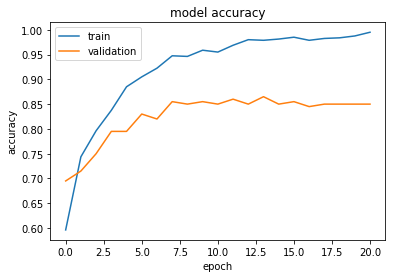

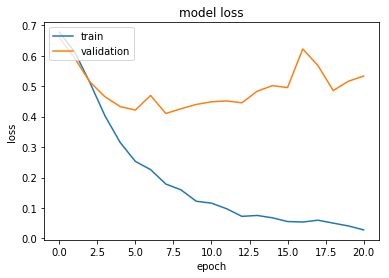

In [50]:
myRNN = model.create_model_LSTM(input_dim, embedding_dim, embedding_matrix, input_len, trainable=True, n1=32, n2=16, d=0.3)
myRNN.summary()

history = myRNN.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=[myCB], verbose=1)
model.plot_curves(history)

### Results:
* We get a training accuracy of 99.50% and testing accuracy of 85.00%.
* The training loss is 0.0278 and testing loss is 0.5333 .

In [52]:
model.save_model(myRNN, "IMDB/LSTM_n132_n216_d03_vacc85")

### Testing on Manually collected data

In [54]:
DNN = tf.keras.models.load_model("../models/DL/IMDB/DNN_n164_n232_kr0015_vacc84.h5")
CNN = tf.keras.models.load_model("../models/DL/IMDB/CNN_n128_D025_kr002_vacc85.h5")
RNN = tf.keras.models.load_model("../models/DL/IMDB/LSTM_n132_n216_d03_vacc85.h5")

In [56]:
test_cases = ["The heart of the show is the relationship between the leads; yet they get about half an episode together. Most storylines lead nowhere and, ultimately, nothing really changes. Dull, hollow, & boring filler.",
             "is a loving tribute to one of the most extraordinary strategic bomb units of WWII... time capsule",
             "Tons of phenomenal archive footage & stills ranging from the launch / moon / space activities, down to period detail, fashion, cars, etc. To this day, an unbelievable feat, deftly re-told and with the detail & scope it deserves. Loved it.",
             "...a tense thriller that's undoubtedly at its best within its often unbearably suspenseful opening half hour...",
              "Yet another tired example of the 'found footage' horror subgenre, this haunted hotel story mainly consists of junky, twitchy video footage and annoying characters who make poor decisions. ",
             "Good movie chemistry between Amitabh & Ayushman was amazing.. Amitabh at his best."]

In [57]:
test_input = []
for test in test_cases:
    instance = tp.preprocess_and_tokenize_test_case(tokenizer, test, padding_type, truncating_type, pad_len)
    test_input.append(instance)

In [58]:
for x in test_input:
    label, confidence = model.predict_label(DNN.predict(x))
    print("label is :{}, and it's confidence is: {}".format(label, confidence))

label is :negative, and it's confidence is: 0.2020861655473709
label is :positive, and it's confidence is: 0.9953317046165466
label is :positive, and it's confidence is: 0.8545721769332886
label is :positive, and it's confidence is: 0.5354936718940735
label is :positive, and it's confidence is: 0.6379318833351135
label is :positive, and it's confidence is: 0.9374701976776123


In [59]:
for x in test_input:
    label, confidence = model.predict_label(CNN.predict(x))
    print("label is :{}, and it's confidence is: {}".format(label, confidence))

label is :negative, and it's confidence is: 0.24309687316417694
label is :positive, and it's confidence is: 0.9631828665733337
label is :positive, and it's confidence is: 0.7609397172927856
label is :positive, and it's confidence is: 0.8521255254745483
label is :negative, and it's confidence is: 0.0513920895755291
label is :positive, and it's confidence is: 0.9312580823898315


In [60]:
for x in test_input:
    label, confidence = model.predict_label(RNN.predict(x))
    print("label is :{}, and it's confidence is: {}".format(label, confidence))

label is :negative, and it's confidence is: 0.0025878525339066982
label is :positive, and it's confidence is: 0.9994317889213562
label is :positive, and it's confidence is: 0.9992005228996277
label is :positive, and it's confidence is: 0.9579780697822571
label is :negative, and it's confidence is: 0.009606458246707916
label is :positive, and it's confidence is: 0.9986624717712402


## Conclusion:
* All the three model can successfully classify a product review as positive or negative.
* The LSTM model seems to be the best one as it's output labels give the highest confidence.
* We can also see how a CNN, which is mostly used in computer vision tasks can be successfully used for text classification.